<a href="https://colab.research.google.com/github/safaiat/CT_EXP/blob/main/pytorch_recon/Feb4v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import torch

# Global variable to store sinogram data
sinogram_output = None

def set_sinogram_parameters():
    # Specify sinogram info
    num_views = 2000
    num_det_rows = 1000
    num_det_channels = 1000
    return num_views, num_det_rows, num_det_channels

@torch.compile
def sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles, output_device, worker):
    """
    Batch the views (angles) and voxels/indices, send batches to the GPU to project, and collect the results.
    """
    max_views = 200
    max_pixels = 8000
    num_to_exclude = 0

    indices = indices[:len(indices)-num_to_exclude]
    angles = angles.to(worker)

    # Batch the views and pixels
    num_views = len(angles)
    view_batch_indices = torch.arange(start=0, end=num_views, step=max_views)
    view_batch_indices = torch.concatenate([view_batch_indices, num_views * torch.ones(1, dtype=torch.int32)])

    num_pixels = len(indices)
    pixel_batch_indices = torch.arange(start=0, end=num_pixels, step=max_pixels)
    pixel_batch_indices = torch.concatenate([pixel_batch_indices, num_pixels * torch.ones(1, dtype=torch.int32)])

    # Create the output sinogram
    sinogram = []

    # Loop over the view batches
    for j, view_index_start in enumerate(view_batch_indices[:2]):
        view_index_end = view_batch_indices[j+1]
        cur_view_batch = torch.zeros([view_index_end-view_index_start, sinogram_shape[1], sinogram_shape[2]], device=worker)
        cur_view_params_batch = angles[view_index_start:view_index_end]

        print('Starting view block {} of {}.'.format(j+1, view_batch_indices.shape[0]-1))

        # Loop over pixel batches
        for k, pixel_index_start in enumerate(pixel_batch_indices[:-1]):
            pixel_index_end = pixel_batch_indices[k+1]
            cur_voxel_batch = voxel_values[pixel_index_start:pixel_index_end].to(worker)
            cur_index_batch = indices[pixel_index_start:pixel_index_end].to(worker)

            def forward_project_pixel_batch_local(view, angle):
                return forward_project_pixel_batch_to_one_view(cur_voxel_batch, cur_index_batch, angle, view, sinogram_shape, recon_shape)

            view_map = torch.vmap(forward_project_pixel_batch_local)
            cur_view_batch = view_map(cur_view_batch, cur_view_params_batch)

        sinogram.append(cur_view_batch.to(output_device))
    sinogram = torch.concatenate(sinogram)
    return sinogram

@torch.compile
def forward_project_pixel_batch_to_one_view(voxel_values, pixel_indices, angle, sinogram_view, sinogram_shape, recon_shape):
    num_views, num_det_rows, num_det_channels = sinogram_shape
    psf_radius = 1
    delta_voxel = 1

    n_p, n_p_center, W_p_c, cos_alpha_p_xy = compute_proj_data(pixel_indices, angle, sinogram_shape, recon_shape)
    L_max = torch.clip(W_p_c, None, 1)

    for n_offset in torch.arange(start=-psf_radius, end=psf_radius+1):
        n = n_p_center + n_offset
        abs_delta_p_c_n = torch.abs(n_p - n)
        L_p_c_n = torch.clamp((W_p_c + 1) / 2 - abs_delta_p_c_n, torch.zeros(1, device=torch.device('cuda')), L_max)
        A_chan_n = delta_voxel * L_p_c_n / cos_alpha_p_xy
        A_chan_n *= (n >= 0) * (n < num_det_channels)
        n = torch.clip(n, 0, num_det_channels - 1)
        update = A_chan_n.reshape((1, -1)) * voxel_values.T
        indices = n.expand(num_det_rows, -1).type(torch.int64)
        sinogram_view = sinogram_view.scatter_add(1, indices, update)

    return sinogram_view

def compute_proj_data(pixel_indices, angle, sinogram_shape, recon_shape):
    cosine = torch.cos(angle)
    sine = torch.sin(angle)

    delta_voxel = 1.0
    dvc = delta_voxel
    dvs = delta_voxel
    dvc *= cosine
    dvs *= sine

    num_views, num_det_rows, num_det_channels = sinogram_shape
    row_index, col_index = torch.unravel_index(pixel_indices, recon_shape[:2])

    y_tilde = dvs * (row_index - (recon_shape[0] - 1) / 2.0)
    x_tilde = dvc * (col_index - (recon_shape[1] - 1) / 2.0)

    x_p = x_tilde - y_tilde
    det_center_channel = (num_det_channels - 1) / 2.0

    n_p = x_p + det_center_channel
    n_p_center = torch.round(n_p).type(torch.int32)

    cos_alpha_p_xy = torch.maximum(torch.abs(cosine), torch.abs(sine))
    W_p_c = cos_alpha_p_xy

    proj_data = (n_p, n_p_center, W_p_c, cos_alpha_p_xy)

    return proj_data

def main():
    """
    This is a script to develop, debug, and tune the parallel beam projector
    """
    global sinogram  # Store sinogram globally for access in Jupyter

    num_views, num_det_rows, num_det_channels = set_sinogram_parameters()
    start_angle = 0
    end_angle = torch.pi
    sinogram_shape = (num_views, num_det_rows, num_det_channels)
    step_size = (end_angle - start_angle) / num_views
    angles = torch.linspace(start=start_angle, end=end_angle - step_size, steps=num_views)

    output_device = torch.device("cpu")
    worker = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    recon_shape = (num_det_channels, num_det_channels, num_det_rows)
    num_recon_rows, num_recon_cols, num_recon_slices = recon_shape[:3]
    phantom = torch.zeros(recon_shape, device=output_device)
    i, j, k = recon_shape[0]//3, recon_shape[1]//2, recon_shape[2]//2
    phantom[i:i+5, j:j+5, k:k+5] = 1.0

    max_index_val = num_recon_rows * num_recon_cols
    indices = torch.arange(max_index_val, dtype=torch.int32)
    voxel_values = phantom.reshape((-1,) + recon_shape[2:])[indices]

    print('Starting forward projection')
    voxel_values.to(output_device)
    indices.to(output_device)
    t0 = time.time()
    sinogram = sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles, output_device=output_device, worker=worker)
    print('Elapsed time:', time.time() - t0)

    #sinogram_output = sinogram  # Store sinogram for Jupyter access

    print('Sinogram shape:', sinogram.shape)
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
        free, total = torch.cuda.mem_get_info(device)
        total_gb = total / (1024 ** 3)
        free_gb = free / (1024 ** 3)
        mem_used_gb = total_gb - free_gb
        print('Used {:.2f}GB of {:.2f}GB total memory'.format(mem_used_gb, total_gb))

if __name__ == "__main__":
    main()


Starting forward projection
Starting view block 1 of 10.
Starting view block 2 of 10.
Elapsed time: 109.44749760627747
Sinogram shape: torch.Size([400, 1000, 1000])
Used 3.17GB of 14.74GB total memory


In [2]:
sinogram.shape

torch.Size([400, 1000, 1000])

In [3]:
import numpy as np
import torch

# Save the sinogram (already available globally) as a NumPy file
np.save("sinogram.npy", sinogram.cpu().numpy())

print("Sinogram saved successfully as 'sinogram.npy'.")


Sinogram saved successfully as 'sinogram.npy'.


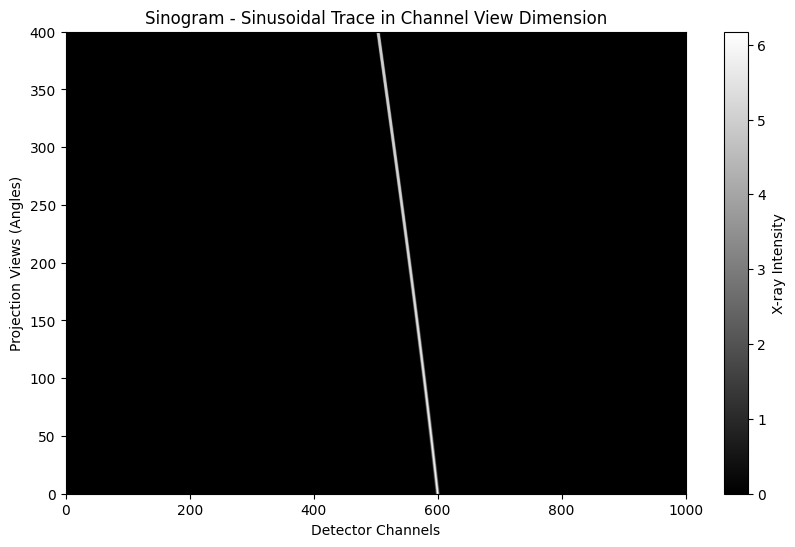

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure sinogram is on CPU and convert to numpy
sinogram_numpy = sinogram.cpu().numpy() if 'sinogram' in globals() and sinogram is not None else None

if sinogram_numpy is not None:
    # Select a specific detector row (middle row)
    row_index = sinogram_numpy.shape[1] // 2  # Middle row

    # Extract data across all views and channels for the selected row
    channel_view_trace = sinogram_numpy[:, row_index, :]

    # Plot the sinusoidal trace of the channel view
    plt.figure(figsize=(10, 6))
    plt.imshow(channel_view_trace, cmap='gray', aspect='auto', extent=[0, channel_view_trace.shape[1], 0, channel_view_trace.shape[0]])
    plt.colorbar(label="X-ray Intensity")
    plt.title("Sinogram - Sinusoidal Trace in Channel View Dimension")
    plt.xlabel("Detector Channels")
    plt.ylabel("Projection Views (Angles)")
    plt.show()

else:
    print("Sinogram data is not available. Please ensure the main function has been executed.")

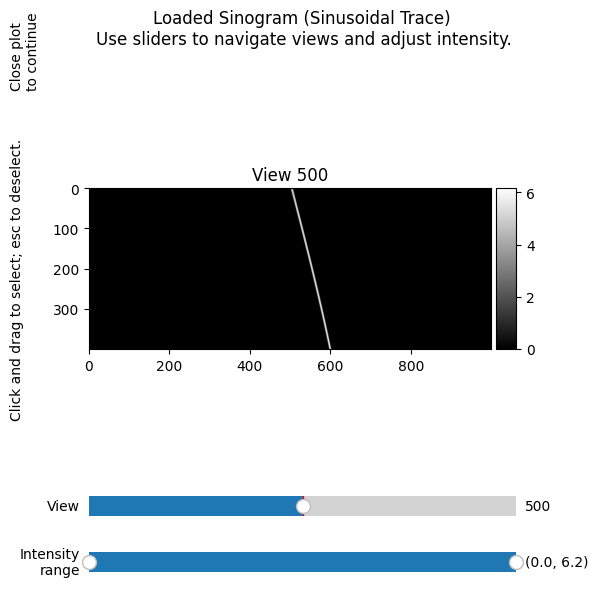

In [5]:


import numpy as np
import jax.numpy as jnp
import mbirjax

# Load the saved sinogram
sinogram = np.load("/content/sinogram.npy")

# Convert sinogram to JAX array
sinogram = jnp.array(sinogram)

# Display sinogram using mbirjax's slice viewer
title = 'Loaded Sinogram (Sinusoidal Trace) \nUse sliders to navigate views and adjust intensity.'
mbirjax.slice_viewer(sinogram, slice_axis=1, title=title, slice_label='View')


In [4]:
import cv2
import numpy as np

# Ensure sinogram is on CPU and convert to numpy
sinogram_numpy = sinogram.cpu().numpy() if 'sinogram' in globals() and sinogram is not None else None

if sinogram_numpy is not None:
    # Video parameters
    num_views, num_rows, num_channels = sinogram_numpy.shape
    fps = 30  # Frames per second
    video_filename = "sinogram_channel_row.mp4"

    # Define the video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 format
    video_writer = cv2.VideoWriter(video_filename, fourcc, fps, (num_channels, num_rows), isColor=False)

    # Normalize the sinogram data for better visualization (scale to 8-bit grayscale)
    normalized_sinogram = cv2.normalize(sinogram_numpy, None, 0, 255, cv2.NORM_MINMAX)
    normalized_sinogram = normalized_sinogram.astype(np.uint8)

    # Generate frames over projection views
    for i in range(num_views):
        frame = normalized_sinogram[i]  # Take each projection as a frame
        video_writer.write(frame)  # Write the frame to the video

    # Release the video writer
    video_writer.release()

    # Provide download link
    print(f"Video saved successfully: {video_filename}")

else:
    print("Sinogram data is not available. Please ensure the main function has been executed.")

Video saved successfully: sinogram_channel_row.mp4


In [5]:
import os
import cv2

# Ensure sinogram is available before saving images
if 'sinogram' in globals() and sinogram is not None:
    # Convert sinogram to numpy and move to CPU if necessary
    sinogram_numpy = sinogram.cpu().numpy()

    # Define output directory for the dataset
    dataset_dir = "xray_dataset"
    os.makedirs(dataset_dir, exist_ok=True)

    # Normalize sinogram for better visualization (convert to 8-bit image format)
    normalized_sinogram = cv2.normalize(sinogram_numpy, None, 0, 255, cv2.NORM_MINMAX)
    normalized_sinogram = normalized_sinogram.astype(np.uint8)

    # Save each X-ray projection as an individual PNG file
    num_projections = normalized_sinogram.shape[0]
    for i in range(num_projections):
        filename = os.path.join(dataset_dir, f"xray_projection_{i:03d}.png")
        cv2.imwrite(filename, normalized_sinogram[i])

    print(f"Dataset created successfully! {num_projections} X-ray images saved in: {dataset_dir}")

else:
    print("Sinogram data is not available. Please ensure the main function has been executed.")

Dataset created successfully! 400 X-ray images saved in: xray_dataset
